## Descriptive Statistics

### Import Libaries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet

from textblob import TextBlob

from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

from collections import Counter
from joblib import Parallel, delayed
from gensim import corpora

import string 
from string import punctuation

import os
import datetime
import time
import re
import requests
import random

import praw

# supress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

In [18]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
# import data 
df = pd.read_csv('data/reddit_posts.csv')
mental_health_support_df = pd.read_csv('data/mental_health_support_posts.csv')
mental_health_df = pd.read_csv('data/mental_health_posts.csv')

In [20]:
df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,157,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,158.585859,1.585859,0.003425
1,What changes your negative thoughts/ has made ...,45,0.99,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,45.454545,0.454545,0.000982
2,what is the point of living?,44,0.93,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,47.311828,3.311828,0.001022
3,I need a hug,25,0.95,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,26.315789,1.315789,0.000568
4,What are you like after a hug,21,0.97,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,21.649485,0.649485,0.000468


In [21]:
mental_health_support_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,157,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,158.585859,1.585859,0.003425
1,What changes your negative thoughts/ has made ...,45,0.99,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,45.454545,0.454545,0.000982
2,what is the point of living?,44,0.93,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,47.311828,3.311828,0.001022
3,I need a hug,25,0.95,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,26.315789,1.315789,0.000568
4,What are you like after a hug,21,0.97,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,21.649485,0.649485,0.000468


In [22]:
mental_health_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,My daughter is scaring me tonight. No idea how...,924,0.98,2023-12-09 02:50:29,My daughter (10) very suddenly this evening sa...,mentalhealth,ajgl1990,False,/r/mentalhealth/comments/18e3pnh/my_daughter_i...,246,942.857143,18.857143,0.002010
1,Brain cancer at 16… I’m a mess now.,830,0.98,2023-11-10 22:18:46,Became extremely I’ll at 16 and told my mom “t...,mentalhealth,Intelligent_Pipe7980,False,/r/mentalhealth/comments/17sfgi8/brain_cancer_...,88,846.938776,16.938776,0.001806
2,I did it. I graduated. I didn’t let depression...,822,0.99,2023-06-14 15:15:05,Depression took over but I won.,mentalhealth,No_Panic2551,False,/r/mentalhealth/comments/149ah8y/i_did_it_i_gr...,137,830.303030,8.303030,0.001770
3,Date raped and now pregnant and I’m just so sad,727,0.94,2023-11-25 04:06:49,I’ve never been to therapy despite a bunch of ...,mentalhealth,Sensitive_World7780,False,/r/mentalhealth/comments/183b3u5/date_raped_an...,61,773.404255,46.404255,0.001649
4,I killed myself on Monday and feel like I will...,662,0.97,2023-07-02 12:58:41,"I think the title says enough, on Monday I lit...",mentalhealth,Dry_Opportunity8703,False,/r/mentalhealth/comments/14onpo2/i_killed_myse...,127,682.474227,20.474227,0.001455


### Text Preprocessing (Tokenization and Normalization)

In [23]:
# tokenization/normalization 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [24]:
# apply preprocessing to 'selftext'
df['tokens'] = df['selftext'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

In [25]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    else:
        return []

# apply preprocessing to 'selftext' in both df
mental_health_support_df['tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in mental_health_support_df['selftext'])
mental_health_df['tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in mental_health_df['selftext'])

# function for analyzing subreddits
def analyze_subreddit(subreddit_df):
    numerical_stats = subreddit_df.describe()
    token_count_stats = subreddit_df['tokens'].apply(len).describe()
    all_tokens = [token for tokens in subreddit_df['tokens'] for token in tokens]
    most_common_words = Counter(all_tokens).most_common(10)
    return numerical_stats, token_count_stats, most_common_words

# sentiment analysis functions
def get_sentiment_category(sentiment):
    if sentiment['compound'] > 0:
        return 'positive'
    elif sentiment['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

def analyze_sentiments(subreddit_df):
    sid = SentimentIntensityAnalyzer()
    subreddit_df['sentiment'] = subreddit_df['selftext'].apply(lambda x: sid.polarity_scores(x) if isinstance(x, str) else {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0})
    subreddit_df['sentiment_category'] = subreddit_df['sentiment'].apply(get_sentiment_category)
    sentiment_stats = subreddit_df['sentiment'].apply(lambda x: x['compound']).describe()
    sentiment_category_counts = subreddit_df['sentiment_category'].value_counts()
    return sentiment_stats, sentiment_category_counts

# function to generate word cloud
def generate_word_cloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# topic modeling function
def topic_modeling(tokens_list, num_topics=5):
    dictionary = corpora.Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    topics = lda_model.print_topics(num_words=10)
    return topics

# time series plot function
def plot_time_series(subreddit_df, title):
    subreddit_df['created_utc'] = pd.to_datetime(subreddit_df['created_utc'], unit='s')
    subreddit_df.set_index('created_utc', inplace=True)
    monthly_counts = subreddit_df.resample('M').size()
    monthly_counts.plot(figsize=(10, 5), title=title)
    plt.ylabel('Number of Posts')
    plt.show()

## Descriptive Statistics 

### r/MentalHealthSupport subreddit

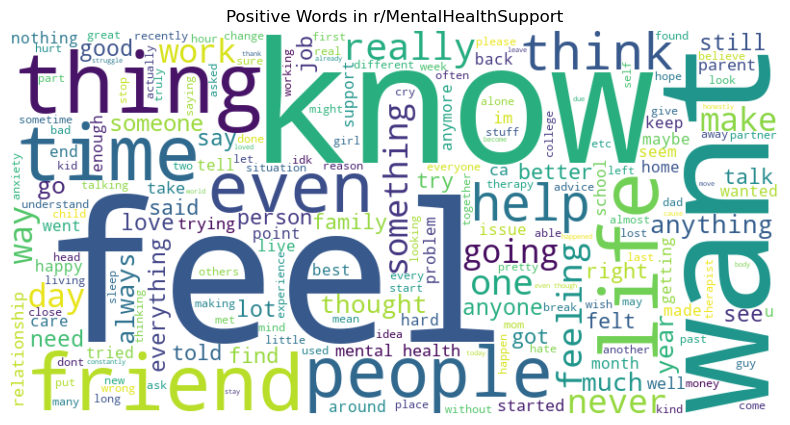

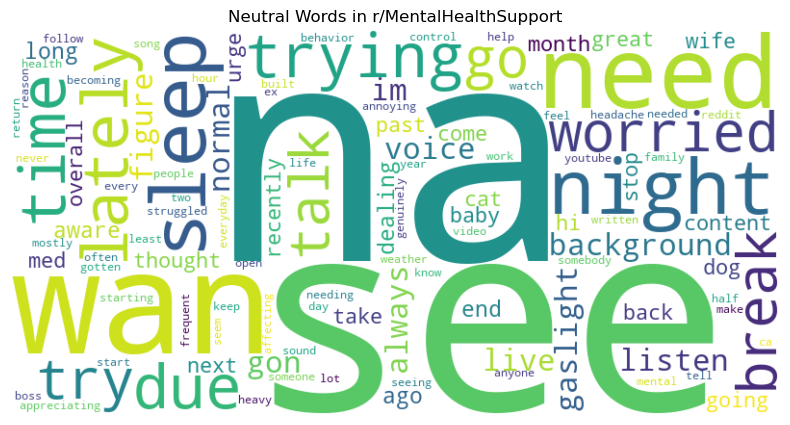

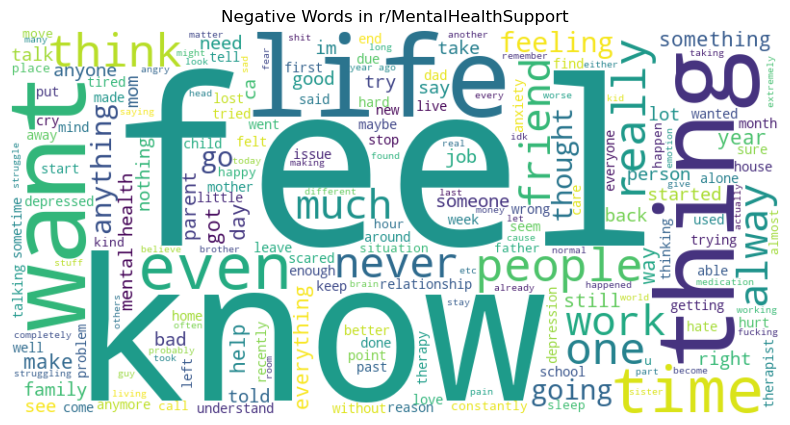


Descriptive Statistics for r/MentalHealthSupport:
Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers
count   1914.000000  1914.000000  1914.000000          1914.000000
mean       2.153605     2.953091     0.129162             0.000064
std        5.373010     4.914273     0.357240             0.000106
min        0.000000     0.000000     0.000000             0.000000
25%        0.000000     1.000000     0.000000             0.000022
50%        0.000000     2.000000     0.000000             0.000043
75%        2.000000     3.000000     0.000000             0.000065
max      154.000000   158.585859     3.311828             0.003425

Token Count Statistics:
 count    1916.000000
mean      113.652401
std       114.976502
min         0.000000
25%        42.000000
50%        80.000000
75%       143.250000
max      1146.000000
Name: tokens, dtype: float64

Most Common Words:
 [('like', 3611), ('feel', 3292), ('know', 2262), ('time', 1893), ('get', 1871),

In [27]:
# r/MentalHealthSupport subreddit
mental_health_support_numerical_stats, mental_health_support_token_count_stats, mental_health_support_common_words = analyze_subreddit(mental_health_support_df)
mental_health_support_sentiment_stats, mental_health_support_sentiment_category_counts = analyze_sentiments(mental_health_support_df)
mental_health_support_topics = topic_modeling(mental_health_support_df['tokens'].tolist())

# word cloud for r/MentalHealthSupport subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealthSupport")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealthSupport")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealthSupport")

# time series analysis for r/MentalHealthSupport subreddit
#plot_time_series(mental_health_support_df, "Posts Over Time in r/MentalHealthSupport")

# statistics for r/MentalHealthSupport subreddit
print("\nDescriptive Statistics for r/MentalHealthSupport:")
print("Numerical Statistics:\n", mental_health_support_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_support_token_count_stats)
print("\nMost Common Words:\n", mental_health_support_common_words)
print("\nSentiment Statistics:\n", mental_health_support_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_support_sentiment_category_counts)

### r/MentalHealth subreddit

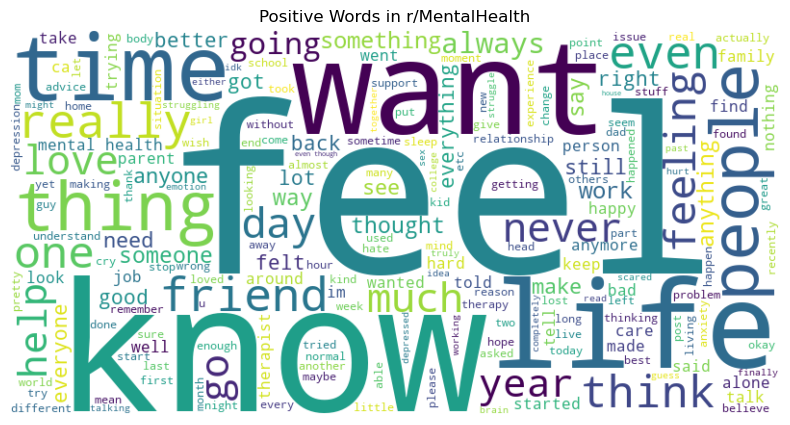

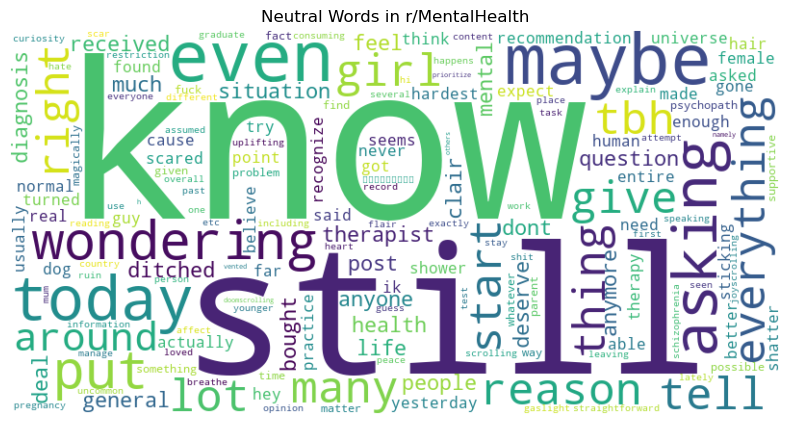

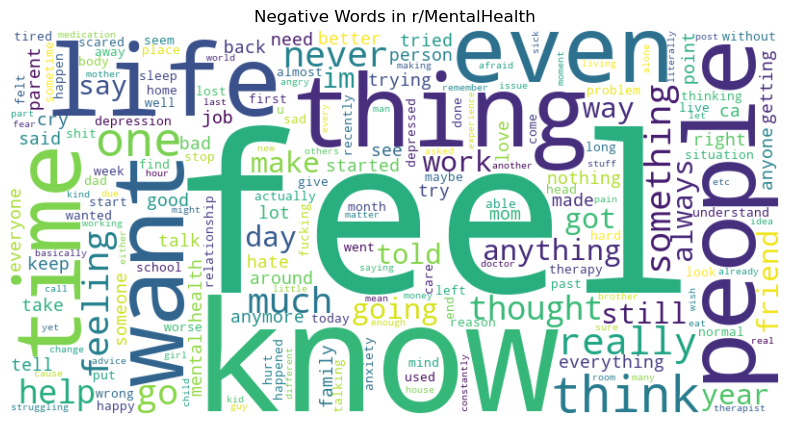

ValueError: non convertible value 2023-12-09 02:50:29 with the unit 's'

In [28]:
# r/MentalHealth subreddit
mental_health_numerical_stats, mental_health_token_count_stats, mental_health_common_words = analyze_subreddit(mental_health_df)
mental_health_sentiment_stats, mental_health_sentiment_category_counts = analyze_sentiments(mental_health_df)
mental_health_topics = topic_modeling(mental_health_df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealth")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealth")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealth")

# time series analysis for r/MentalHealth subreddit
plot_time_series(mental_health_df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for r/MentalHealth:")
print("Numerical Statistics:\n", mental_health_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_token_count_stats)
print("\nMost Common Words:\n", mental_health_common_words)
print("\nSentiment Statistics:\n", mental_health_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_sentiment_category_counts)

### combined subreddits

In [ ]:
# combine both df into one
mental_health_support_df.reset_index(inplace=True)
mental_health_df.reset_index(inplace=True)

df = pd.concat([mental_health_support_df, 
                mental_health_df], 
               ignore_index=True)

# save processed dataframes to CSV files
df.to_csv('data/reddit_posts_cleaned.csv', index=False)

In [ ]:
# combined subreddit
df_numerical_stats, df_token_count_stats, df_common_words = analyze_subreddit(df)
df_sentiment_stats, df_sentiment_category_counts = analyze_sentiments(df)
df_topics = topic_modeling(df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(df['tokens'],df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in combined subreddit")
generate_word_cloud(neutral_words, "Neutral Words in combined subreddit")
generate_word_cloud(negative_words, "Negative Words in combined subreddit")

# time series analysis for combined subreddit
plot_time_series(df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for combined subreddit:")
print("Numerical Statistics:\n", df_numerical_stats)
print("\nToken Count Statistics:\n", df_token_count_stats)
print("\nMost Common Words:\n", df_common_words)
print("\nSentiment Statistics:\n", df_sentiment_stats)
print("\nSentiment Category Counts:\n", df_sentiment_category_counts)

In [ ]:
# save processed dataframes to CSV files
mental_health_support_df.to_csv('data/mental_health_support_cleaned.csv', index=False)
mental_health_df.to_csv('data/mental_health_cleaned.csv', index=False)

In [ ]:
# tokenization/normalization 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [ ]:
# apply preprocessing to 'selftext'
df['tokens'] = df['selftext'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

In [ ]:
# descriptive statistics
numerical_stats = df.describe()
token_count_stats = df['tokens'].describe()

In [ ]:
# most common words
all_tokens = [token for tokens in df['tokens'] for token in tokens]
fdist = FreqDist(all_tokens)
most_common_words = fdist.most_common(10)

In [ ]:
# output statistics
print("Numerical Statistics:\n", numerical_stats)
print("\nToken Count Statistics:\n", token_count_stats)
print("\nMost Common Words:\n", most_common_words)

The descriptive statistics were reviewed separately for each subreddit (r/MentalHealth and r/MentalHealthSupport) rather than in a combined manner. By focusing individually on each subreddit, we can gain deeper insights into specific trends within each subreddit.

In [ ]:
# reviwing as seperate df 
mental_health_support_df = pd.read_csv('data/mental_health_support_posts.csv')
mental_health_df = pd.read_csv('data/mental_health_posts.csv')

In [ ]:
stop_words = set(stopwords.words('english'))

# removing additional stop words
#additional_stopwords = {'like', 'feel', 'know', 'get', 'time', 'want', 'life', 'even', 'thing', 'year'}
#stop_words = stop_words.union(additional_stopwords)
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def analyze_subreddit(subreddit_df):
    subreddit_df['tokens'] = subreddit_df['selftext'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
    numerical_stats = subreddit_df.describe()
    token_count_stats = subreddit_df['tokens'].apply(len).describe()
    all_tokens = [token for tokens in subreddit_df['tokens'] for token in tokens]
    fdist = FreqDist(all_tokens)
    most_common_words = fdist.most_common(10)
    return numerical_stats, token_count_stats, most_common_words

def analyze_sentiments(subreddit_df):
    sid = SentimentIntensityAnalyzer()
    
    def get_sentiment_category(sentiment):
        if sentiment['compound'] > 0:
            return 'positive'
        elif sentiment['compound'] < 0:
            return 'negative'
        else:
            return 'neutral'
    
    # Perform sentiment analysis and store results in new columns
    subreddit_df['sentiment'] = subreddit_df['selftext'].apply(lambda x: sid.polarity_scores(x) if isinstance(x, str) else {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0})
    
    subreddit_df['sentiment_category'] = subreddit_df['sentiment'].apply(get_sentiment_category)
    
    # Extract compound score for description
    sentiment_stats = subreddit_df['sentiment'].apply(lambda x: x['compound']).describe()
    
    # Count sentiment categories
    sentiment_category_counts = subreddit_df['sentiment_category'].value_counts()
    
    return sentiment_stats, sentiment_category_counts

def analyze_sentiments_vader(texts):
    sid = SentimentIntensityAnalyzer()
    sentiments = []
    for text in texts:
        if isinstance(text, str):
            sentiment = sid.polarity_scores(text)
        else:
            sentiment = sid.polarity_scores('')
        sentiments.append(sentiment)
    return sentiments

def generate_word_cloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

def topic_modeling(tokens_list, num_topics=5):
    dictionary = corpora.Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    topics = lda_model.print_topics(num_words=10)
    return topics

def plot_time_series(subreddit_df, title):
    subreddit_df.set_index('created_utc', inplace=True)
    monthly_counts = subreddit_df.resample('M').size()
    monthly_counts.plot(figsize=(10, 5), title=title)
    plt.ylabel('Number of Posts')
    plt.show()

In [10]:
#'r/MentalHealthSupport' subreddit
mental_health_support_numerical_stats, mental_health_support_token_count_stats, mental_health_support_common_words = analyze_subreddit(mental_health_support_df)
mental_health_support_sentiment_stats, mental_health_support_sentiment_category_counts = analyze_sentiments(mental_health_support_df)
mental_health_support_topics = topic_modeling(mental_health_support_df['tokens'].tolist())

# extract words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))


print("\nDescriptive Statistics for r/MentalHealthSupport:")
print("Numerical Statistics:\n", mental_health_support_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_support_token_count_stats)
print("\nMost Common Words:\n", mental_health_support_common_words)
print("\nSentiment Statistics:\n", mental_health_support_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_support_sentiment_category_counts)


print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Descriptive Statistics for r/MentalHealthSupport:
Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers
count   1921.000000  1921.000000  1921.000000          1921.000000
mean       2.138470     2.940360     0.131406             0.000064
std        5.325898     4.912228     0.355495             0.000106
min        0.000000     0.000000     0.000000             0.000000
25%        0.000000     1.000000     0.000000             0.000022
50%        0.000000     2.000000     0.000000             0.000043
75%        2.000000     3.000000     0.000000             0.000065
max      154.000000   160.606061     3.462366             0.003469

Token Count Statistics:
 count    1923.000000
mean      113.549662
std       115.038961
min         0.000000
25%        42.000000
50%        80.000000
75%       142.000000
max      1146.000000
Name: tokens, dtype: float64

Most Common Words:
 [('like', 3619), ('feel', 3317), ('know', 2269), ('time', 1903), ('get', 1883),

In [11]:
#'r/MentalHealth' subreddit
mental_health_numerical_stats, mental_health_token_count_stats, mental_health_common_words = analyze_subreddit(mental_health_df)
mental_health_sentiment_stats, mental_health_sentiment_category_counts = analyze_sentiments(mental_health_df)
mental_health_topics = topic_modeling(mental_health_df['tokens'].tolist())

# extract words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nDescriptive Statistics for r/MentalHealth:")
print("Numerical Statistics:\n", mental_health_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_token_count_stats)
print("\nMost Common Words:\n", mental_health_common_words)
print("\nSentiment Statistics:\n", mental_health_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_sentiment_category_counts)

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Descriptive Statistics for r/MentalHealth:
Numerical Statistics:
              score  upvote_ratio  num_comments      upvotes    downvotes  \
count  2042.000000   2042.000000   2042.000000  2042.000000  2042.000000   
mean     55.695397      0.952870     31.820274    58.495695     2.800298   
std      93.493854      0.091493     56.339860    97.387250     6.375583   
min       0.000000      0.280000      0.000000     0.000000     0.000000   
25%       1.000000      0.950000      1.000000     1.000000     0.000000   
50%      11.000000      0.990000      8.000000    11.978261     0.492537   
75%      69.750000      1.000000     42.000000    72.979167     2.678106   
max     930.000000      1.000000    616.000000   948.979592    61.769231   

       upvotes/subscribers  
count          2042.000000  
mean              0.000125  
std               0.000208  
min               0.000000  
25%               0.000002  
50%               0.000026  
75%               0.000156  
max             